See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [ ]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'no'  #@param ["yes", "no"]

if use_gdrive == 'yes':
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/vision_transformer_colab'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

In [ ]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 49 (delta 6), reused 15 (delta 1), pack-reused 0
Receiving objects: 100% (49/49), 2.02 MiB | 7.54 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Already up to date.


In [ ]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-wqiiuvim


### Imports

In [ ]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [ ]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][400.0 MiB/400.0 MiB]   11.7 MiB/s                                   
Operation completed over 1 objects/400.0 MiB.                                    


In [ ]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [ ]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[cuda(id=0)]

In [ ]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.
from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [ ]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  # cifar10=('yes','no'),
  cifar10=('Bike Path','Cycle Track','Local Street Bikeway','Multi-Use Path','no','Painted Bike Lane'),
  #cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

Connect to google drive in order to import dataset from google drive;
Because google streeview should not be cropped, I commented out the cropping lines in input_pipeline.py.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dataset = 'cifar10'
batch_size = 512
batch_eval_size = 200
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.batch_eval = batch_eval_size
config.pp.crop = 224

In [ ]:
# For details about setting up datasets, see input_pipeline.py on the right.
#ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_train = input_pipeline.get_data_from_directory(directory='/content/drive/MyDrive/six_classes/train',config=config, mode='train')
#ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
ds_test = input_pipeline.get_data_from_directory(directory='/content/drive/MyDrive/six_classes/test',config=config, mode='test')
num_classes = 6
del config  # Only needed to instantiate datasets.

In [ ]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(1, 200, 224, 224, 3)

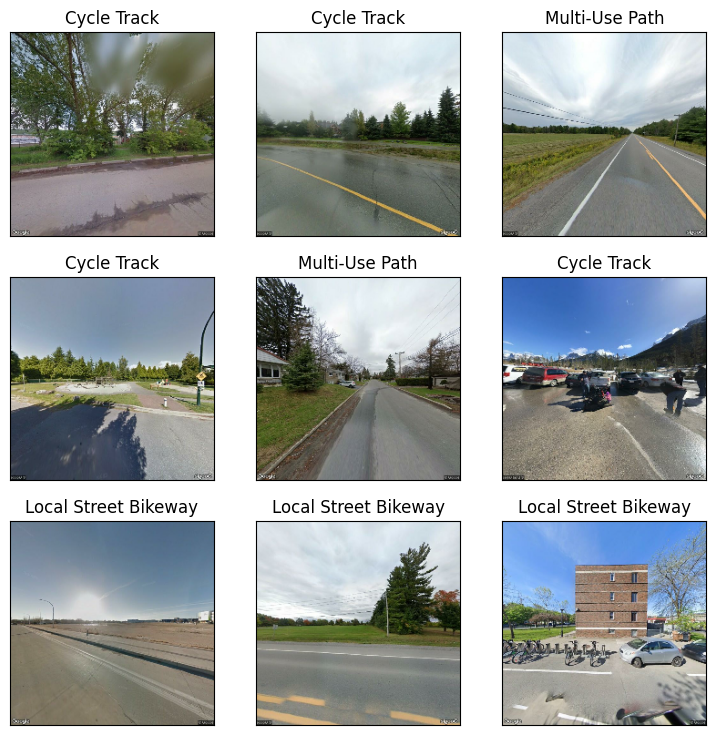

In [ ]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [ ]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [ ]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [ ]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [ ]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (4,)
params_repl.cls: ArrayImpl (1, 4)


In [ ]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [ ]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = 1
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [ ]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

100%|██████████| 1/1 [00:33<00:00, 33.46s/it]


Array(0.16666666, dtype=float32)

### Fine-tune

In [ ]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 200
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [ ]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [ ]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 200/200 [18:44<00:00,  5.62s/it]


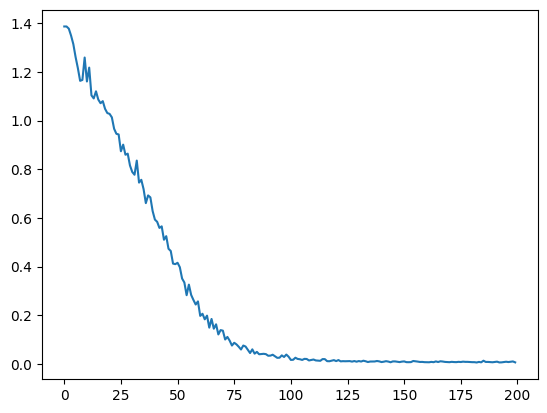

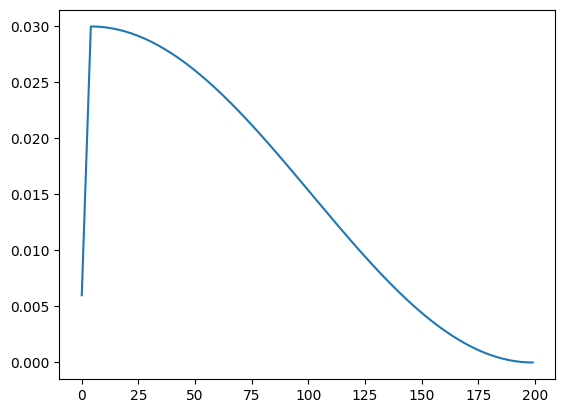

In [ ]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [ ]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

100%|██████████| 1/1 [00:36<00:00, 36.51s/it]


Array(0.575, dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix

for _, batch in zip(tqdm.trange(1), ds_test.as_numpy_iterator()):
  predicted = vit_apply_repl(params_repl, batch['image'])
  predicted_value = predicted.argmax(axis=-1)
  ground_truth = batch['label'].argmax(axis=-1)

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


In [ ]:
class_names = ["Local Street Bikeway","Multi-Use Path","Painted Bike Lane","no"]
print(sorted(class_names))

confusion_matrix(predicted_value.flatten(), ground_truth.flatten())

['Local Street Bikeway', 'Multi-Use Path', 'Painted Bike Lane', 'no']


array([[21,  0,  1,  2],
       [ 2, 30,  3,  8],
       [ 3,  3, 27,  3],
       [24, 17, 19, 37]])

### Inference

In [ ]:
# Load and convert pretrained checkpoint.
# params = checkpoint.load(f'{model_name}_imagenet2012.npz')
checkpoint_dir = "/content/drive/MyDrive/six_classes/saved_checkpoint"
params, _, _ = flax_checkpoints.restore_checkpoint(
      checkpoint_dir, (params_repl, opt_state, 0))
params['pre_logits'] = {}

INFO:absl:Restoring orbax checkpoint from /content/drive/MyDrive/six_classes/saved_checkpoint/checkpoint_0
INFO:absl:Restoring item from /content/drive/MyDrive/six_classes/saved_checkpoint/checkpoint_0.


ValueError: The sharded dimension must be equal to the number of devices passed to PmapSharding. Got sharded dimension 0 with value 768 in shape (768,) and the number of devices=1

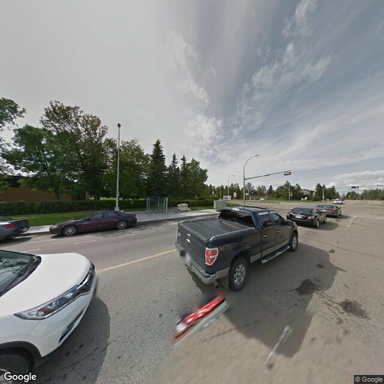

In [ ]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
import PIL
img_path = "/content/drive/MyDrive/six_classes/test/Painted Bike Lane/0209.jpeg"
img = PIL.Image.open(img_path).resize((resolution,resolution))
img

In [ ]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

ScopeParamShapeError: Initializer expected to generate shape (1, 50, 768) but got shape (1, 145, 768) instead for parameter "pos_embedding" in "/Transformer/posembed_input". (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeParamShapeError)

In [ ]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.52548 : lakeside, lakeshore
0.16299 : promontory, headland, head, foreland
0.12497 : volcano
0.04307 : valley, vale
0.02912 : cliff, drop, drop-off
0.02730 : seashore, coast, seacoast, sea-coast
0.01116 : dam, dike, dyke
0.00892 : geyser
0.00597 : sandbar, sand_bar
0.00570 : alp
